Importamos las bibliotecas correspondientes

In [1]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from copy import *
%matplotlib notebook
#plt.rcParams["figure.figsize"] = (5,5)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Funciones de inicialización de posiciones y velocidades

In [3]:
def lattice_pos(npart,r):
    """
    Distribuye homogeneamente npart particulas en una celda
    de 1x1 entre 0 y 1, agregando un r/100% de aleatoriedad. 
    Devuelve un np.array de npart de posiciones x 2 coordenadas

    """

    #Calculo cantidad de celdas por lado
    n = int(np.ceil(np.sqrt(npart)))
    
    #calculo el centro de la celda
    nf = 1.0/float(n)
    
    #Calculo las posiciones de todas las celdas disponibles agregando un r% de randomizacion
    #r = 0.02
    celdas = [[i*nf +0.5*nf + r*np.random.rand(),j*nf + 0.5*nf+ r*np.random.rand()]
              for i in range(n) for j in range(n)]
    
    #Mezclo las posiciones de las celdas
    np.random.shuffle(celdas)
    
    X = np.array(celdas[0:npart])
    return X

def vel_ini(npart,temp_red):
    """
    Asigna velocidades al azar de la distribucion uniforme en el rango -0.5 a 0.5

    """
    V = np.random.rand(npart,2)-0.5*np.ones((npart,2), dtype=np.float)
    
    #Calculamos la velocidad del centro de masa
    Vx = sum(V[:,0])/npart
    Vy = sum(V[:,1])/npart
    
    #Calculamos la velocidad cuadratica media
    V2 = sum(sum(V**2))/npart
    
    #Factor de escala para temperatura
    fs = np.sqrt(2*temp_red/V2)
    
    #Elimino la velocidad del centro de masa y escalo
    V[:,0] = (V[:,0] - Vx)*fs
    V[:,1] = (V[:,1] - Vy)*fs
    
    return V

def init(npart,box,temp_red,dt_red,sigma):
    """
    inicializa posiciones y velocidades usando lattice_pos y vel_ini

    """    
    r = 0.00
    X = lattice_pos(npart,r)
    
    #Escalo posiciones al tamanio de caja y lo reduzco con sigma
    X = (X*box)/sigma
    V = vel_ini(npart,temp_red) 
    
    return X,V

Función para calcular las fuerzas usando Lennard-Jones en condiciones periódicas

In [4]:
def force(npart,X,rcut,box,epsilon):
    """
    Calcula las fuerzas de todas las particulas utilizando un potencial de Lennard-Jones.
    Las distancias ya estan reducidas por sigma y utiliza un radio de corte rcut.
    Las fuerzas son devueltas en unidades reducidas y las energias en kJ/mol

    """ 
    
    #inicializo las fuerzas a 0.0 y la energia a 0.0
    F = np.zeros((npart,2),dtype=np.float)
    Epot = 0.0
    
    #Calculo la energia de cutoff en unidades reducidas
    rci6 = 1.0/rcut**6
    rci12= rci6**2
    Ecut = 4.0*(rci12 -rci6)
    
    #Calculo la fuerza sobre todos los pares de particulas
    for i in range(npart-1):
        for j in range(i+1,npart):
            rx = X[i,0] - X[j,0]
            rx = rx - box*np.rint(rx/box)
            ry = X[i,1] - X[j,1]
            ry = ry - box*np.rint(ry/box)
            r2 = rx**2 + ry**2
            
            if r2 < rcut**2:
                r2i = 1/r2
                r6i = r2i**3
                ff = 48.0*r2i*r6i*(r6i-0.5)
                
                # F tiene unidades de reducidas
                F[i,0] = F[i,0] + ff*rx
                F[j,0] = F[j,0] - ff*rx

                F[i,1] = F[i,1] + ff*ry
                F[j,1] = F[j,1] - ff*ry

                Epot = Epot + 4.0*r6i*(r6i-1.0) - Ecut
                
    return [F,Epot*epsilon] #Fuerza en unidades reducidas y energia en kJ/mol


Funciones para calcular posiciones y velocidades usando velocity Verlet en condiciones periódicas

In [5]:
def pos(npart,X,V,F,dt,box,m):
    """
    Calcula las nuevas posiciones usando el algoritmo de velocity Verlet.
    Todas las distancias están reducidas. Las nuevas posiciones son devueltas en 
    coordenadas reducidas.

    """ 
    
    Xnew = X + V*dt + (F/(2.0*m))*dt**2
    
    #Se fija si la partícula salió de la caja y la transporta a
    #la posición correspondiente de su imagen
    np.where(Xnew[:,0] > box, Xnew[:,0] - box, Xnew[:,0])
    np.where(Xnew[:,0] < 0.0, box + Xnew[:,0], Xnew[:,0])
    np.where(Xnew[:,1] > box, Xnew[:,1] - box, Xnew[:,1])
    np.where(Xnew[:,1] < 0.0, box + Xnew[:,1], Xnew[:,1])
    
    return Xnew

def vel(npart,V,F,Fnew,dt,m):
    """
    Calcula las nuevas velocidades usando el algoritmo de velocity Verlet.
    Las nuevas velocidades son devueltas en coordenadas reducidas y la energía
    cinética está en kJ/mol

    """ 
    Vnew = V + (0.5/m)*(Fnew + F)*dt
    
    V2 = sum(sum(Vnew**2))
    Ekin = 0.5*V2*epsilon
    
    return Vnew, Ekin

Función de inicialización de simulación que genera unidades reducidas y otros parámetros relevantes para simular, y función que genera una corrida (capaz de controlar la temperatura usando un termostato de Berendsen)

In [6]:
def inicializar(npart, box, temperatura, dt, sigma, epsilon, masa):
    """
    Inicializa una simulación en función de la cantidad de partículas (npart),
    el tamaño de la caja en angstroms (box), una temperatura (K), el paso de simulación
    (dt) en segundos, los parámetros de Lennard-Jones sigma y epsilon (en A y kJ/mol)
    y la masa de la partícula (en g/mol). Devuelve coordenadas, velocidades y fuerzas iniciales en
    unidades reducidas y un diccionario con parámetros de la corrida (unit_red)

    """     
    NA = 6.02e23 # 1/mol
    kB = 1.381e-23 # J/K
    
    rcut = box/2.0 # A (unidades reales)
    
    #reduzco el tiempo
    t_unit = (sigma*1e-10) * np.sqrt(masa*1e-3/(1000*epsilon))
    dt_red = dt/t_unit

    #reduzco la temperatura
    temp_unit = 1.0/(kB/(1000*epsilon/NA))
    temp_red = temperatura/temp_unit

    #reduzco la masa
    m_unit = masa*1e-3/NA
    m = 1

    #Posiciones y Velocidad inicial
    X, V = init(npart,box,temp_red,dt_red,sigma)

    #Calculo fuerzas iniciales
    F,Epot = force(npart,X,rcut/sigma,box/sigma,epsilon)

    unit_red = {'t_unit': t_unit, 'T_unit': temp_unit, 'm_unit': m_unit, 'E_unit':epsilon, 'x_unit': sigma,
               'box': box/sigma, 'rcut':rcut/sigma, 'Temp0':temperatura, 'sigma':sigma, 'epsilon':epsilon,
                'dt':dt, 'm':m}
    
    return X, V, F, unit_red

def simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq):
    """
    Corre una simulación nsteps pasos a partir de las coordenadas, velocidades
    y fuerzas iniciales. Si se provee un tau_ber > 0, utiliza un termostato de
    Berendsen para realizar una simulación a T constante (provista en los parámetros 
    de la corrida). plot_freq define cada cuantos pasos se grafica. Además de los gráficos
    de posición en función del paso, Temperatura y Energías, provee coordenadas, velocidades
    y fuerzas finales de la simulación.

    """   
    sigma = unit_red['sigma']
    epsilon = unit_red['epsilon']
    dt = unit_red['dt']/unit_red['t_unit']
    box = unit_red['box']
    temp0 = unit_red['Temp0']
    m = unit_red['m']
    rcut = unit_red['rcut']
    temp_unit = unit_red['T_unit']
    
    if plot_freq < nsteps:
        fig = plt.figure()
        ax1 = fig.add_subplot(2,2,1)
        ax2 = fig.add_subplot(2,2,3)
        ax3 = fig.add_subplot(2,2,2)
        fig.show()
        fig.canvas.draw()

    #inicializo
    E = np.zeros((nsteps,2))
    T = np.zeros((nsteps,1))
    
    if tau_ber > 0:
        berendsen = True
    else:
        berendsen = False

    for i in range(nsteps):
        #Calculo Posicion
        Xnew = pos(npart,X,V,F,dt,box,m)

        #Calculo Fuerzas nuevas
        Fnew, Epot = force(npart,Xnew,rcut,box,epsilon)
        E[i,0] = Epot
    
        #Calculo velocidad
        Vnew, Ekin = vel(npart,V,F,Fnew,dt,m)
        E[i,1] = Ekin
        T_i = sum(sum(Vnew**2))/(2*npart)*temp_unit 
        T[i] = T_i
    
        if berendsen:
            l = np.sqrt(1 + (dt/tau_ber)*(temp0/T_i - 1))
            Vnew = Vnew*l
    
        #Actualizo variables
        X = copy(Xnew)
        V = copy(Vnew)
        F = copy(Fnew)
    
        if (plot_freq < nsteps) and (i % plot_freq == 0):
            ax1.clear()
            ax1.plot(X[:,0]*sigma,X[:,1]*sigma,'b.')
    
            ax1.axis('equal')
            ax1.set_aspect('equal', 'box')
            ax1.set_xlim(0,box*sigma)
            ax1.set_ylim(0,box*sigma)
        
            ax2.clear()
            ax2.plot((E[0:i,0]+ E[0:i,1])/npart,'r', label = 'Total')
            ax2.plot(E[0:i,0]/npart,'g', label = 'Potencial')
            ax2.plot(E[0:i,1]/npart,'b', label = 'Cinetica')
            ax2.set_xlabel('#Paso')
            ax2.set_ylabel('E(kJ/mol)')
            ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fancybox=True, shadow=True)
        
            ax3.clear()
            ax3.plot(T[0:i],'r')
            ax3.plot((i+1)*[temp0],'k--')
            ax3.set_xlabel('#Paso')
            ax3.set_ylabel('T(K)')
        
            fig.canvas.draw()
            
    return X, V, F

Generación de una corrida. Inicialización de parámetros y simulación. Termalización a 119.8K por 2000 pasos.

<IPython.core.display.Javascript object>


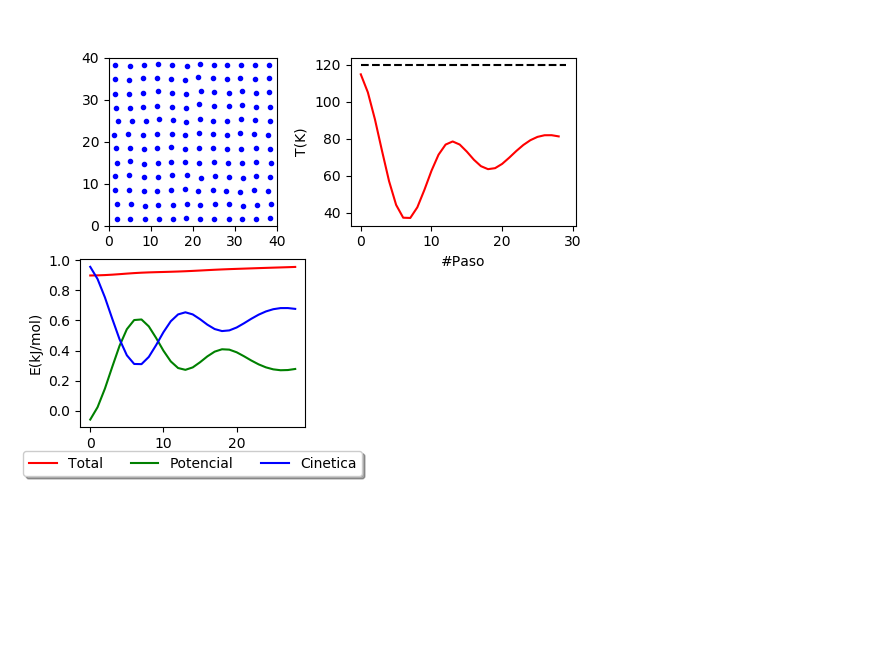

KeyboardInterrupt: 

In [7]:
#Corrida
nsteps = 2000
npart  =  144
box = 40
temperatura = 119.8 #K
dt = 1e-14 # en segundos 
sigma = 3.405 #A
epsilon = 0.996 #kJ/mol
masa = 39.95 #g/mol
tau_ber = 1
plot_freq = 1

#Inicializo con berendsen tau = 1 y corro 2000 pasos
X, V, F, unit_red = inicializar(npart, box, temperatura, dt, sigma, epsilon, masa)
X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)

In [12]:
X

array([[ 8.81057269,  8.81057269],
       [ 8.81057269,  2.93685756]])

Testeo eliminar el termostato. Corrida de otros 2000 pasos.

<IPython.core.display.Javascript object>


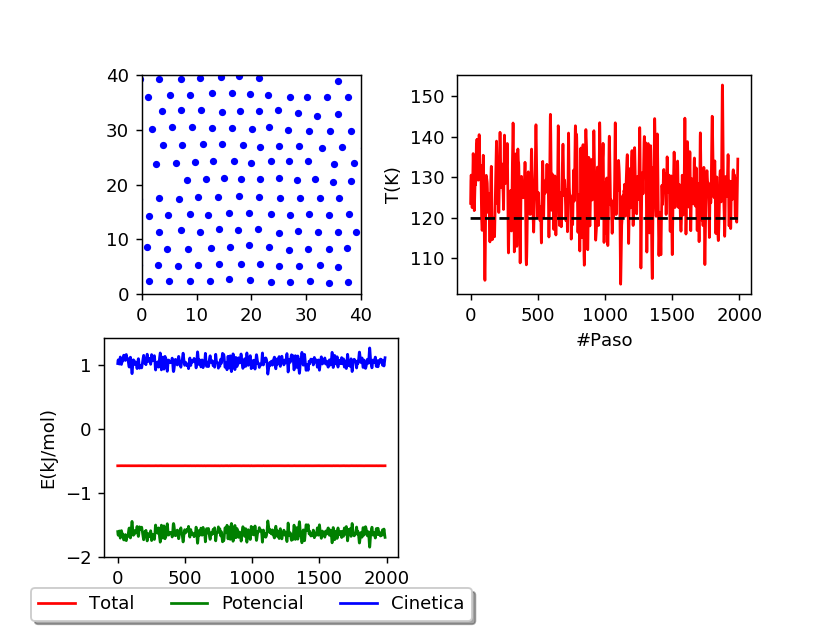

In [29]:
#Pongo berendsen tau = 0 y corro 2000 pasos
nsteps = 2000
tau_ber = 0
X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)
V120 = copy(V)

Cambio la T a 200K y pongo el termostato.

<IPython.core.display.Javascript object>


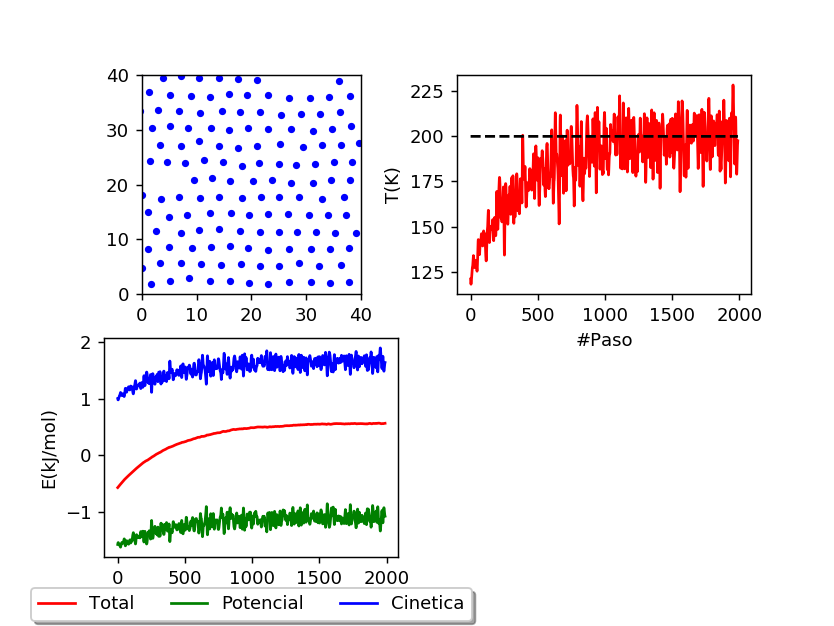

In [30]:
#Cambio la temperatura del sistema a T = 200K, pongo un berendsen y corro 2000 pasos
unit_red['Temp0'] = 200
tau_ber = 1.0
nsteps = 2000
X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)

Elimino el termostato y chequeo que la T se mantiene.

<IPython.core.display.Javascript object>


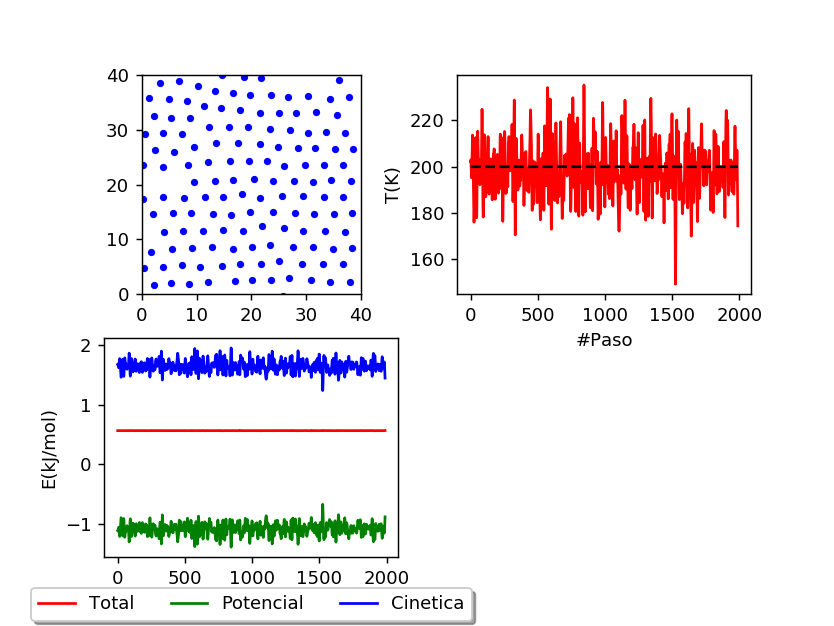

In [31]:
#Pongo berendsen tau = 0 y corro 2000 pasos
nsteps = 2000
tau_ber = 0
plot_freq = 10
X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)
V200 = copy(V)

Enfrio el sistema a 50K usando el Berendsen.

<IPython.core.display.Javascript object>


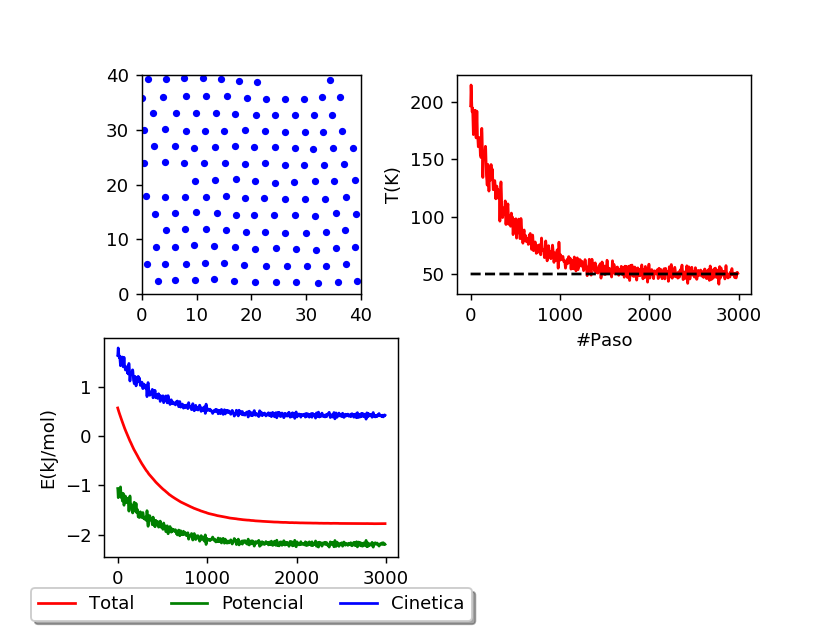

In [32]:
#Cambio la temperatura del sistema a T = 50K, pongo un berendsen y corro 1000 pasos
unit_red['Temp0'] = 50
tau_ber = 1.0
nsteps = 3000
X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)

Elimino el Berendsen y veo la dinámica.

<IPython.core.display.Javascript object>


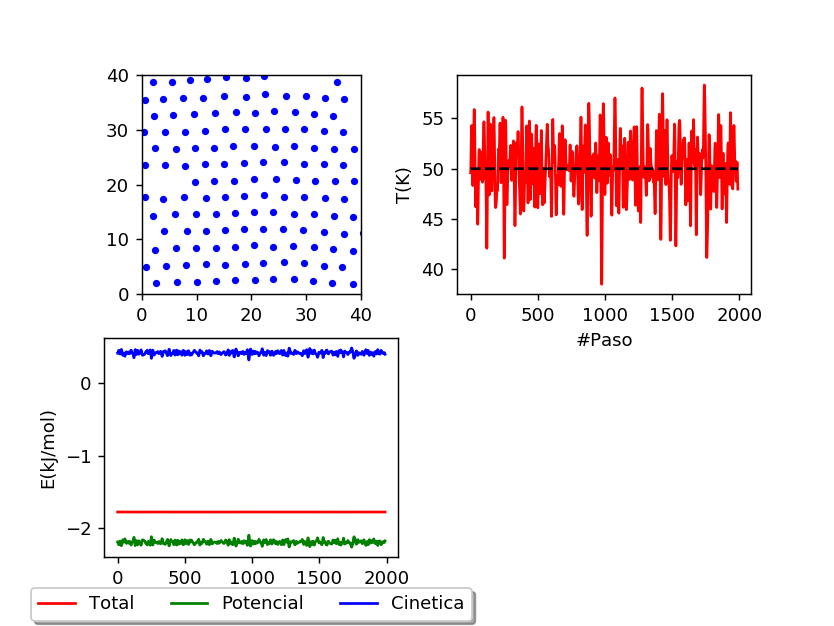

In [33]:
#Pongo berendsen tau = 0 y corro 2000 pasos
nsteps = 2000
tau_ber = 0
plot_freq = 10
X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)
V50 = copy(V)

Grafico histogramas de las velocidades a las distintas temperaturas para los sistemas termalizados pero sin termostato.

<IPython.core.display.Javascript object>


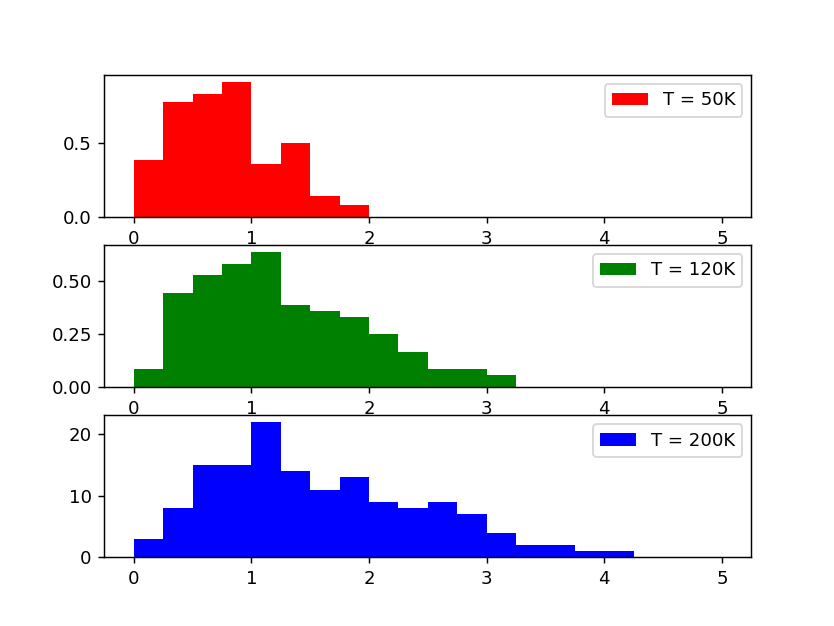

In [83]:
fig = plt.figure()
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)
ax1.hist(np.sqrt(np.sum(V50**2, axis=1)), range = (0.0, 5.0), bins = 20, label= 'T = 50K', color = 'r', density=True)
ax1.legend()
ax2.hist(np.sqrt(np.sum(V120**2, axis=1)), range = (0.0, 5.0), bins = 20, label= 'T = 120K', color = 'g', density=True)
ax2.legend()
ax3.hist(np.sqrt(np.sum(V200**2, axis=1)), range = (0.0, 5.0), bins = 20, label= 'T = 200K', color = 'b')
ax3.legend()
plt.show()

Para aumentar la estádistica de los histogramas, termalizo y manteniendo el termostato realizo 10 simulaciones de 500 pasos, guardando las velocidades de las partículas. Asumo que en 500 pasos las velocidades están descorrelacionadas y por lo tanto es como muestrear independientemente las velocidades.

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


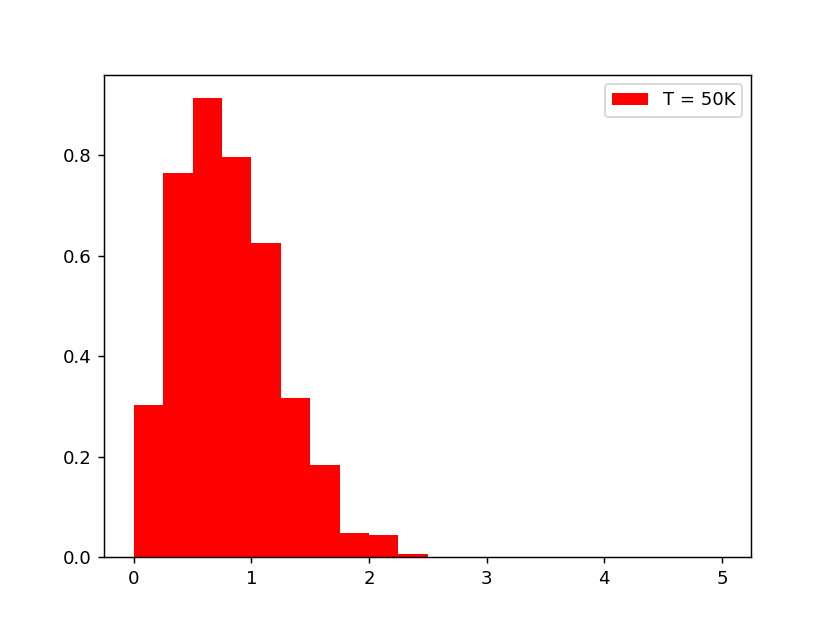

In [86]:
V50_x10 = []
nsim = 10
for i in range(nsim):
    print(i)
    nsteps = 500
    tau_ber = 1.0
    unit_red['Temp0'] = 50
    plot_freq = 1000
    X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)
    V50_x10.append(np.sqrt(np.sum(V**2, axis=1)))
V50_x10 = np.array(V50_x10)
V50_x10 = V50_x10.reshape(npart*nsim,1)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(V50_x10, range = (0.0, 5.0), bins = 20, label= 'T = 50K', color = 'r', density = True)
ax1.legend()
plt.show()

Repito a 100K

<IPython.core.display.Javascript object>


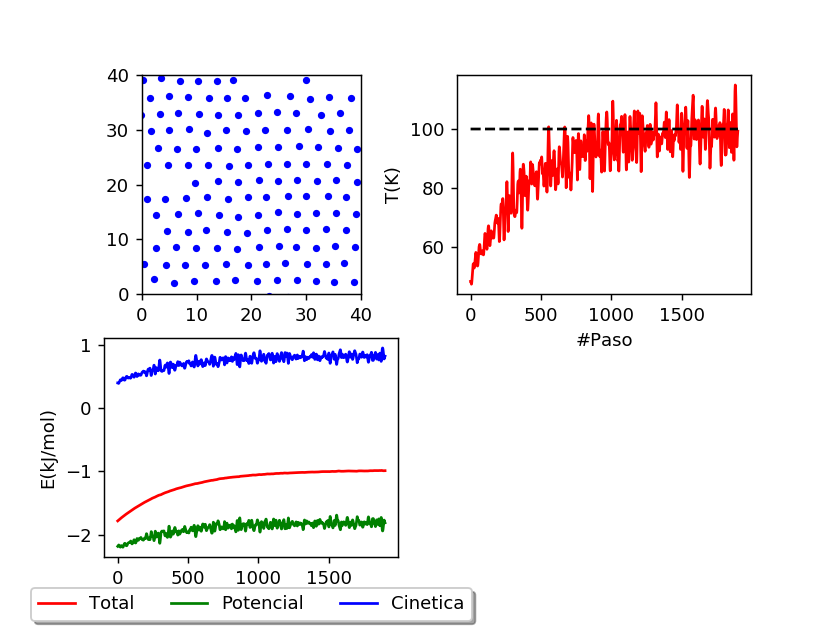

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


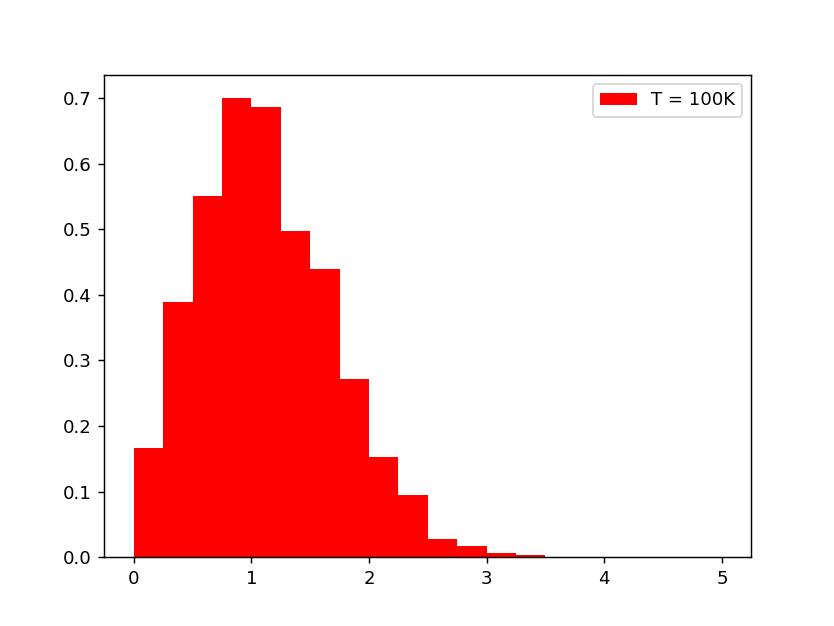

In [88]:
nsteps = 2000
tau_ber = 1.0
unit_red['Temp0'] = 100
plot_freq = 100
X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)

V100_x10 = []
nsim = 10
for i in range(nsim):
    print(i)
    nsteps = 500
    tau_ber = 1.0
    unit_red['Temp0'] = 100
    plot_freq = 1000
    X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)
    V100_x10.append(np.sqrt(np.sum(V**2, axis=1)))
V100_x10 = np.array(V100_x10)
V100_x10 = V100_x10.reshape(npart*nsim,1)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(V100_x10, range = (0.0, 5.0), bins = 20, label= 'T = 100K', color = 'r', density = True)
ax1.legend()
plt.show()

Repito a 200K

<IPython.core.display.Javascript object>


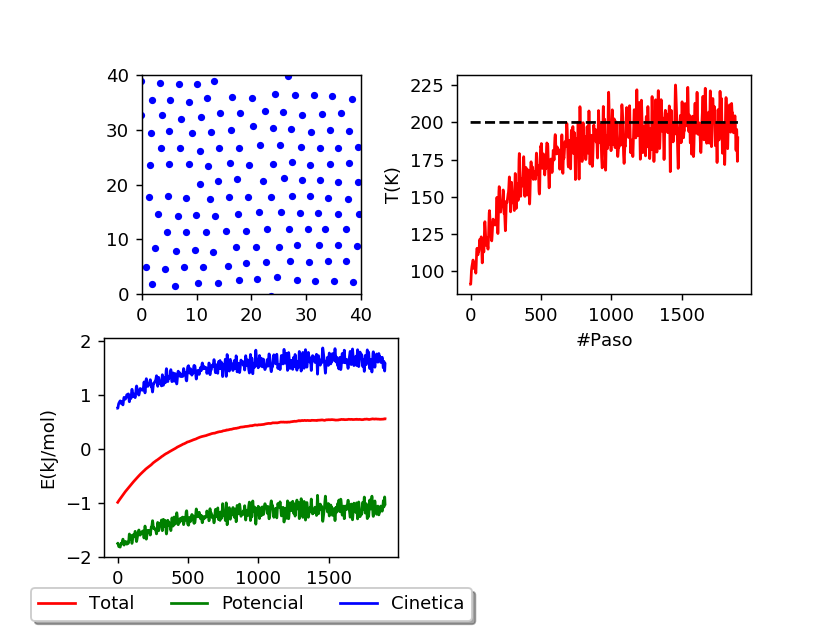

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


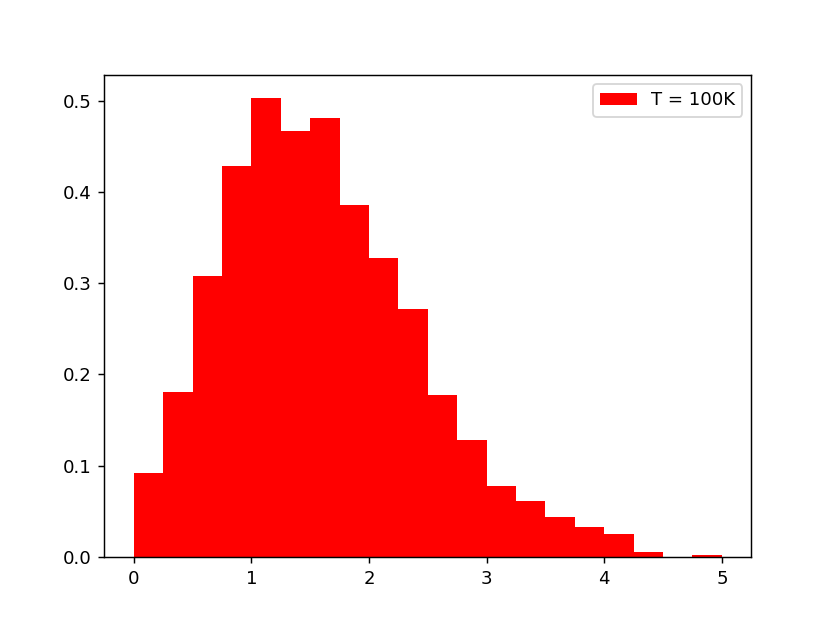

In [89]:
nsteps = 2000
tau_ber = 1.0
unit_red['Temp0'] = 200
plot_freq = 100
X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)

V200_x10 = []
nsim = 10
for i in range(nsim):
    print(i)
    nsteps = 500
    tau_ber = 1.0
    unit_red['Temp0'] = 200
    plot_freq = 1000
    X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)
    V200_x10.append(np.sqrt(np.sum(V**2, axis=1)))
V200_x10 = np.array(V200_x10)
V200_x10 = V200_x10.reshape(npart*nsim,1)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(V200_x10, range = (0.0, 5.0), bins = 20, label= 'T = 200K', color = 'r', density = True)
ax1.legend()
plt.show()

Repito a 400K!

<IPython.core.display.Javascript object>


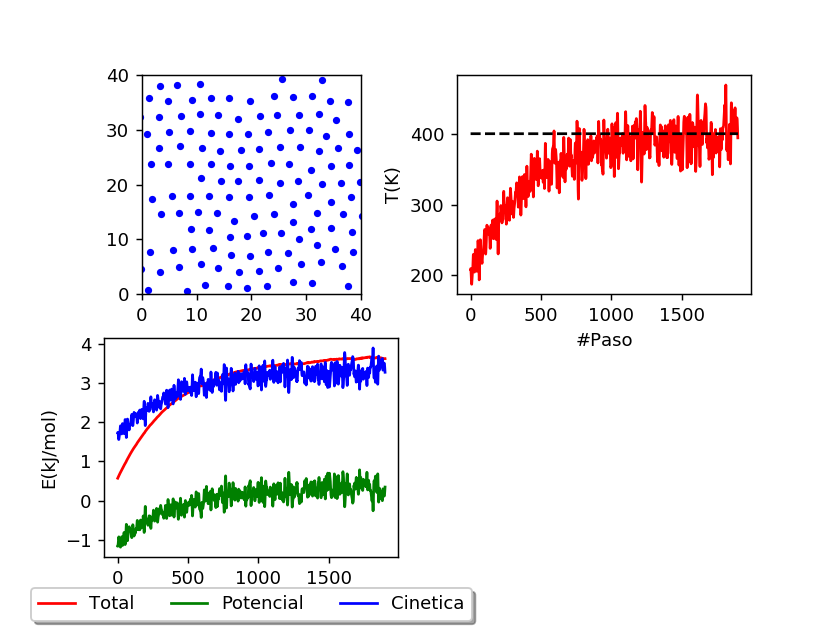

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


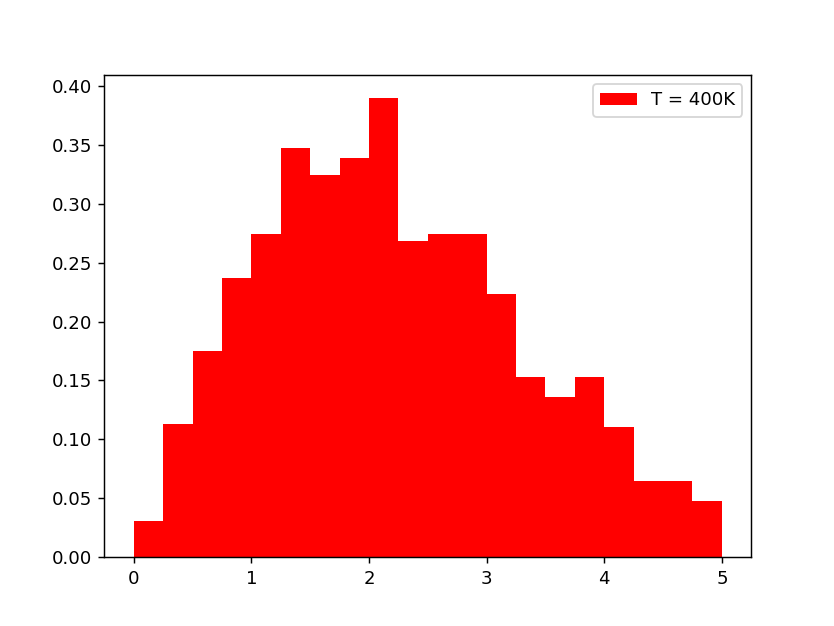

In [90]:
nsteps = 2000
tau_ber = 1.0
unit_red['Temp0'] = 400
plot_freq = 100
X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)

V400_x10 = []
nsim = 10
for i in range(nsim):
    print(i)
    nsteps = 500
    tau_ber = 1.0
    unit_red['Temp0'] = 400
    plot_freq = 1000
    X, V, F = simular(nsteps, X, V, F, unit_red, tau_ber, plot_freq)
    V400_x10.append(np.sqrt(np.sum(V**2, axis=1)))
V400_x10 = np.array(V400_x10)
V400_x10 = V400_x10.reshape(npart*nsim,1)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(V400_x10, range = (0.0, 5.0), bins = 20, label= 'T = 400K', color = 'r', density = True)
ax1.legend()
plt.show()

Grafico todos los histogramas juntos... Boltzman!

<IPython.core.display.Javascript object>


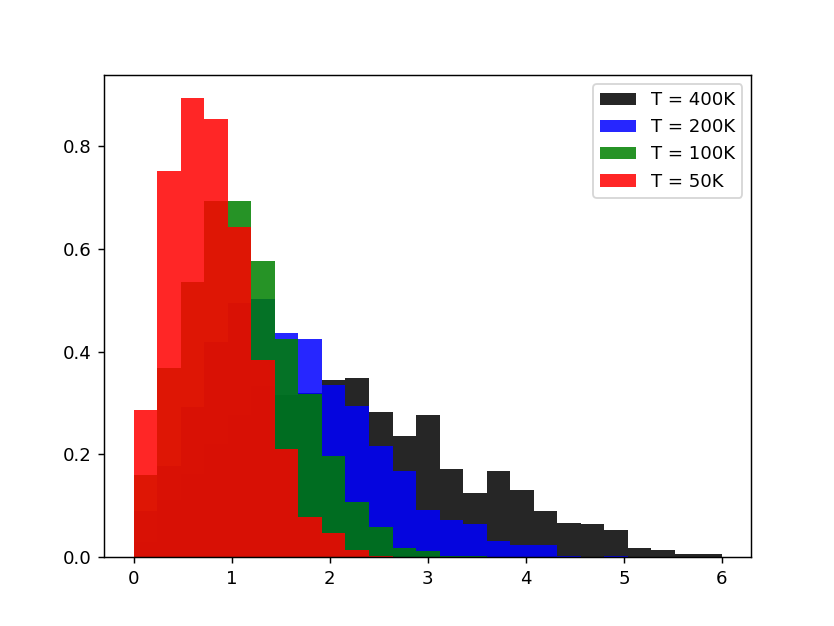

In [103]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(V400_x10, range = (0.0, 6.0), bins = 25, label= 'T = 400K', color = 'k', alpha = 0.85, density=True)
ax1.hist(V200_x10, range = (0.0, 6.0), bins = 25, label= 'T = 200K', color = 'b', alpha = 0.85, density=True)
ax1.hist(V100_x10, range = (0.0, 6.0), bins = 25, label= 'T = 100K', color = 'g', alpha = 0.85, density=True)
ax1.hist(V50_x10, range = (0.0, 6.0), bins = 25, label= 'T = 50K', color = 'r', alpha = 0.85, density=True)
ax1.legend()
plt.show()